# LGBM을 활용한 베이스라인

In [97]:
import pandas as pd
import os
import random
from collections import defaultdict
import time
from datetime import datetime

## 1. 데이터 로딩

In [112]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

In [103]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'test4.csv')
df1 = pd.read_csv(csv_file_path) 
df1 = df1[['testId','test_level_diff']]
df1.drop_duplicates(['testId'], inplace=True)
df = pd.merge(df,df1,on ='testId' )

In [58]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'test6.csv')
df2 = pd.read_csv(csv_file_path) 
df2 = df2[['KnowledgeTag','test_level_diff']]
df2.drop_duplicates(['KnowledgeTag'], inplace=True)
df = pd.merge(df,df2,on ='KnowledgeTag' )

In [63]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'df1.csv')
df3 = pd.read_csv(csv_file_path) 
df3 = df3[['userID','Timestamp','rank_point']]
df = pd.merge(df,df3,on =['userID','Timestamp'])

In [113]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [51]:
test_df

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,answer_min_count,answer_max_count,user_count,test_level_diff_x,test_level_diff_y,test_level_diff
0,0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,3.0,27.0,218,0.220183,0.211009,0.215674
1,1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,2.0,26.0,218,0.220183,0.211009,0.215674
2,2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,1.0,25.0,218,0.220183,0.211009,0.215674
3,3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,3.0,24.0,218,0.192661,0.211009,0.215674
4,4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,0.0,17.0,218,0.155963,0.211009,0.215674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,175588,2452,A090006002,A090000006,0,2020-11-11 06:19:09,4709,1.0,8.0,48,0.291667,0.236111,0.132972
260110,175589,2452,A090006003,A090000006,1,2020-11-11 06:19:12,4723,1.0,8.0,48,0.291667,0.236111,0.132972
260111,175590,2452,A090006004,A090000006,0,2020-11-11 06:19:14,4723,2.0,9.0,48,0.291667,0.236111,0.132972
260112,175591,2452,A090006005,A090000006,1,2020-11-11 06:19:16,4723,1.0,8.0,48,0.291667,0.236111,0.132972


## 2. Feature Engineering

In [55]:
def time_takeover(df):
    
    def convert_time(s):
        timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
        return int(timestamp)

    df['sec_time']=df['Timestamp'].apply(convert_time)
    df['solve_time']=df['sec_time'].shift(-1)-df['sec_time']
    
    answer=pd.DataFrame()
    
    for user in df['userID'].unique():
        interactions=df[df['userID']==user]
        interactions=interactions.sort_values(by=['testId','Timestamp'], inplace=False)
        upper_inter=interactions[interactions['testId']==interactions['testId'].shift(-1)]
        tat=upper_inter.groupby('testId').agg({'solve_time':'mean'}).reset_index(drop=False)  
        testid_avg_time_dict=dict(zip(tat['testId'],tat['solve_time']))
        
        under_inter=interactions[interactions['testId']!=interactions['testId'].shift(-1)]

        under_inter['solve_time']=under_inter['testId'].apply(lambda x:testid_avg_time_dict[x])
        
        total_user=pd.concat([upper_inter,under_inter], ignore_index=True).sort_values(by=['Timestamp'], inplace=False)
        answer=pd.concat([answer,total_user], ignore_index=True)
    return answer

In [58]:
kk=time_takeover(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

KeyboardInterrupt: 

In [59]:
kk

NameError: name 'kk' is not defined

In [114]:
def test_diff_fun(df):
    def percentile(s):        
        return np.sum(s) / len(s)

    def fun(x):
        if x > 0.8 :
            return 5
        elif x <=0.8 and x >0.6 :
            return 4   
        elif x <=0.6 and x >0.4 :
            return 3
        elif x <=0.4 and x >0.2 :
            return 2
        elif x <=0.2  :
            return 1
        
    df1=df.groupby('userID').agg({'answerCode': percentile})
    df1.columns = ["test_rate"]
    df1.reset_index(inplace = True)
    
    df2 = df1.copy()
    df2['level']=pd.Series([fun(x) for x in df2['test_rate']])
    del df2['test_rate']
    df = pd.merge(df,df2,on='userID')
    
    df3 =df.groupby(['assessmentItemID','level']).agg({'answerCode':['sum','count']})      
    df3.reset_index(inplace=True)
    df3.columns = ['assessmentItemID','point','sum','count']
    
    df4 = df3.copy()
    df4 = df4.sort_values(by="point", ascending=True).groupby("assessmentItemID").head(1)
    df4.drop(["point", "count"], axis=1,inplace = True)
#     del df4['point']
#     del df4['count']    
    df4.columns = ['assessmentItemID','answer_min_count']

    df5 = df3.copy()
    df5 = df5.sort_values(by="point", ascending=False).groupby("assessmentItemID").head(1)
    df5.drop(["point", "count"], axis=1,inplace = True)
#     del df5['point']
#     del df5['count']
    df5.columns = ['assessmentItemID','answer_max_count']
    
    df = pd.merge(df,df4,on='assessmentItemID')
    df = pd.merge(df,df5,on='assessmentItemID')
    
    df6 = df.groupby('assessmentItemID').agg({'userID':'count'})
    df6.columns = ['user_count']
    df = pd.merge(df,df6,on='assessmentItemID')
    df['test_level_diff_itemID']=pd.Series((df['answer_max_count']-df['answer_min_count'])/(df['user_count']/2))
    
    df.drop(["answer_max_count", "answer_min_count",'user_count'], axis=1,inplace = True)
###################################################################################################   
    df7 =df.groupby(['KnowledgeTag','level']).agg({'answerCode':['sum','count']})      
    df7.reset_index(inplace=True)
    df7.columns = ['KnowledgeTag','point','sum','count']
    
    df8 = df7.copy()
    df8= df8.sort_values(by="point", ascending=True).groupby("KnowledgeTag").head(1)
    del df8['point']
    del df8['count']
    df8.columns = ['KnowledgeTag','answer_min_count']

    df9 = df7.copy()
    df9 = df9.sort_values(by="point", ascending=False).groupby("KnowledgeTag").head(1)
    del df9['point']
    del df9['count']
    df9.columns = ['KnowledgeTag','answer_max_count']
    
    df = pd.merge(df,df8,on='KnowledgeTag')
    df = pd.merge(df,df9,on='KnowledgeTag')
    
    df10 = df.groupby('KnowledgeTag').agg({'userID':'count'})
    df10.columns = ['user_count']
    df = pd.merge(df,df10,on='KnowledgeTag')
    
    df['test_level_diff_tag']=pd.Series((df['answer_max_count']-df['answer_min_count'])/(df['user_count']/2))
    
    return df[['assessmentItemID','KnowledgeTag','test_level_diff_itemID','test_level_diff_tag']]


In [117]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer_total'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer_total'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc_total'] = df['user_correct_answer_total']/df['user_total_answer_total']
    
    df['user_correct_answer'] = df.groupby(['userID','testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby(['userID','testId'])['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    
    df['user_correct_answer_tag'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer_tag'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].cumcount()
    df['user_acc_tag'] = df['user_correct_answer_tag']/df['user_total_answer_tag']
       

#     testId와 KnowledgeTag의 전체 정답률은 한번에 계산
#     아래 데이터는 제출용 데이터셋에 대해서도 재사용
#     correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
#     correct_t.columns = ["test_mean", 'test_sum']
#     correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
#     correct_k.columns = ["tag_mean", 'tag_sum']

#     df = pd.merge(df, correct_t, on=['testId'], how="left")
#     df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [ ]:
df = feature_engineering(df)
df.head()

In [ ]:
df1 = test_diff_fun(df)   
df = pd.merge(df,df1,on =['assessmentItemID','KnowledgeTag])

In [77]:
df['testId'] = df['testId'].astype('category')
df['assessmentItemID'] = df['assessmentItemID'].astype('category')

## 3. Train/Test 데이터 셋 분리

In [48]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [29]:
test_df=test_df[(test_df['answerCode']==0) | (test_df['answerCode']==1)]
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

In [93]:
# 유저별 분리
train, test = custom_train_test_split(df)
# train = df
# test = test_df

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','test_level_diff_x','test_level_diff_y','answer_min_count','answer_max_count']
FEATS = ['KnowledgeTag','user_correct_answer', 'user_total_answer', 
         'user_acc','user_correct_answer_tag', 'user_total_answer_tag', 'user_acc_tag','test_level_diff_x','test_level_diff_y','rank_point'] #,'user_correct_answer_tag', 'user_total_answer_tag', 'user_acc_tag',
# FEATS = ['KnowledgeTag','test_level_diff_x','test_level_diff_y','user_acc','user_acc_tag']


# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [7]:
# !pip install lightgbm

     |████████████████████████████████| 2.0 MB 2.1 MB/s eta 0:00:01


In [94]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [95]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [96]:
model = lgb.train(
                    {'objective': 'binary', 
                    'metric':'auc'},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=5000,
                    early_stopping_rounds=100
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1050401, number of negative: 568670
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1511
[LightGBM] [Info] Number of data points in the train set: 1619071, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648768 -> initscore=0.613627
[LightGBM] [Info] Start training from score 0.613627
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.807803	valid_1's auc: 0.782327
[200]	training's auc: 0.812544	valid_1's auc: 0.783883
[300]	training's auc: 0.815639	valid_1's auc: 0.786197
[400]	training's auc: 0.817986	valid_1's auc: 0.787586
[500]	training's auc: 0.820235	valid_1's auc: 0.788863
[600]	training's auc: 0.82208	valid_1's auc: 0.79028
[700]	training's auc: 0.823808	valid_1's auc: 

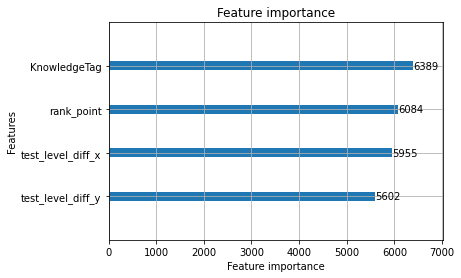

In [85]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [106]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test2.csv')
test_df = pd.read_csv(test_csv_file_path)

In [107]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'test5.csv')
df1 = pd.read_csv(csv_file_path) 
df2 = df1[['testId','test_level_diff']]
df2.drop_duplicates(['testId'], inplace=True)
test_df = pd.merge(test_df,df2,on ='testId' )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [109]:
test_df.to_csv('test_total_csv.csv')

In [50]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'test7.csv')
df1 = pd.read_csv(csv_file_path) 
df2 = df1[['testId','test_level_diff']]
df2.drop_duplicates(['testId'], inplace=True)
test_df = pd.merge(test_df,df2,on ='testId' )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [36]:
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'df2.csv')
df3 = pd.read_csv(csv_file_path) 
df3 = df3[['userID','Timestamp','rank_point']]
test_df = pd.merge(test_df,df3,on =['userID','Timestamp'])

In [37]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

In [38]:
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [39]:
test_df

,Unnamed: 0,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,answer_min_count,answer_max_count,user_count,test_level_diff_x,test_level_diff_y,rank_point,user_correct_answer,user_total_answer,user_acc,user_correct_answer_tag,user_total_answer_tag,user_acc_tag
22857,1034,3,A050133007,A050000133,2020-10-26 13:13:11,5289,0.0,30.0,233,0.257511,0.278970,2526.0,6.0,6,1.000000,9.0,10,0.900000
43371,1705,4,A070146007,A070000146,2020-12-27 02:47:31,9080,2.0,18.0,137,0.233577,0.186131,2335.0,5.0,6,0.833333,1.0,2,0.500000
80219,3022,13,A070111007,A070000111,2020-12-27 04:35:01,9660,0.0,13.0,215,0.120930,0.120930,3050.0,2.0,6,0.333333,1.0,5,0.200000
110323,4282,17,A090064005,A090000064,2020-10-30 05:47:22,2611,2.0,9.0,92,0.152174,0.105072,4027.0,4.0,4,1.000000,4.0,4,1.000000
70417,4669,26,A060135006,A060000135,2020-10-23 11:44:01,1422,0.0,33.0,222,0.297297,0.317889,1548.0,4.0,5,0.800000,4.0,5,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234045,260051,7395,A040122004,A040000122,2020-09-08 02:05:18,2102,3.0,43.0,261,0.306513,0.291188,1013.0,1.0,3,0.333333,1.0,1,1.000000
253328,260066,7404,A030111004,A030000111,2020-10-13 09:47:31,7636,5.0,48.0,264,0.325758,0.306061,1011.0,1.0,3,0.333333,1.0,3,0.333333
173837,260081,7416,A050193003,A050000193,2020-10-04 02:44:17,10402,0.0,23.0,225,0.204444,0.246667,1008.0,2.0,2,1.000000,2.0,2,1.000000
173840,260096,7417,A050193003,A050000193,2020-09-06 13:08:54,10402,0.0,23.0,225,0.204444,0.246667,1001.0,2.0,2,1.000000,2.0,2,1.000000


In [40]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [41]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "output.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output.csv
